<a href="https://colab.research.google.com/github/tenorio74/machine_learning/blob/main/Pokemon_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokemon Classification

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import PIL
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import imageio
import time
from IPython import display

Using TensorFlow backend.


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
# Extract Data from google drive
local_zip = '/content/drive/My Drive/Colab Notebooks/PokemonGen1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
GENERATE_RES =4 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3


# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 30
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


## Data Preprocessing

In [ ]:
pokemon2label ={
    "Bulbasaur":1,"Ivysaur":2,"Venusaur":3,"Charmander":4,"Charmeleon":5,"Charizard":6,"Squirtle":7,"Wartortle":8,"Blastoise":9,"Caterpie":10,
    "Metapod":11,"Butterfree":12,"Weedle":13,"Kakuna":14,"Beedrill":15,"Pidgey":16,"Pidgeotto":17,"Pidgeot":18,"Rattata":19,"Raticate":20,
    "Spearow":21,"Fearow":22,"Ekans":23,"Arbok":24,"Pikachu":25,"Raichu":26,"Sandshrew":27,"Sandslash":28,"Nidoran-f":29,"Nidorina":30,
    "Nidoqueen":30,"Nidoran-m":32,"Nidorino":33,"Nidoking":34,"Clefairy":35,"Clefable":36,"Vulpix":37,"Ninetales":38,"Jigglypuff":39,"Wigglytuff":40,
    "Zubat":41,"Golbat":42,"Oddish":43,"Gloom":44,"Vileplume":45,"Paras":46,"Parasect":47,"Venonat":48,"Venomoth":49,"Diglett":50,"Dugtrio":51,
    "Meowth":52,"Persian":53,"Psyduck":54,"Golduck":55,"Mankey":56,"Primeape":57,"Growlithe":58,"Arcanine":59,"Poliwag":60,"Poliwhirl":61,
    "Poliwrath":62,"Abra":63,"Kadabra":64,"Alakazam":65,"Machop":66,"Machoke":67,"Machamp":68,"Bellsprout":69,"Weepinbell":70,"Victreebel":71,
    "Tentacool":72,"Tentacruel":73,"Geodude":74,"Graveler":75,"Golem":76,"Ponyta":77,"Rapidash":78,"Slowpoke":79,"Slowbro":80,"Magnemite":81,
    "Magneton":82,"Farfetchd":83,"Doduo":84,"Dodrio":85,"Seel":86,"Dewgong":87,"Grimer":88,"Muk":89,"Shellder":90,"Cloyster":91,"Gastly":92,
    "Haunter":93,"Gengar":94,"Onix":95,"Drowzee":96,"Hypno":97,"Krabby":98,"Kingler":99,"Voltorb":100,"Electrode":101,"Exeggcute":102,
    "Exeggutor":103,"Cubone":104,"Marowak":105,"Hitmonlee":106,"Hitmonchan":107,"Lickitung":108,"Koffing":109,"Weezing":110,"Rhyhorn":111,"Rhydon":112,
    "Chansey":113,"Tangela":114,"Kangaskhan":115,"Horsea":116,"Seadra":117,"Goldeen":118,"Seaking":119,"Staryu":120,"Starmie":121,"MrMime":122,
    "Scyther":123,"Jynx":124,"Electabuzz":125,"Magmar":126,"Pinsir":127,"Tauros":128,"Magikarp":129,"Gyarados":130,"Lapras":131,"Ditto":132,
    "Eevee":133,"Vaporeon":134,"Jolteon":135,"Flareon":136,"Porygon":137,"Omanyte":138,"Omastar":139,"Kabuto":140,"Kabutops":141,"Aerodactyl":142,
    "Snorlax":143,"Articuno":144,"Zapdos":145,"Moltres":146,"Dratini":147,"Dragonair":148,"Dragonite":149,"Mewtwo":150,"Mew":151
}
label2pokemon = {v : k for k, v in pokemon2label.items()}

# label2pokemon = { 
#     1:"Bulbasaur",2:"Ivysaur",3:"Venusaur",4:"Charmander",5:"Charmeleon",6:"Charizard",7:"Squirtle",8:"Wartortle",9:"Blastoise",10:"Caterpie",
#     11:"Metapod",12:"Butterfree",13:"Weedle",14:"Kakuna",15:"Beedrill",16:"Pidgey",17:"Pidgeotto",18:"Pidgeot",19:"Rattata",20:"Raticate",
#     21:"Spearow",22:"Fearow",23:"Ekans",24:"Arbok",25:"Pikachu",26:"Raichu",27:"Sandshrew",28:"Sandslash",29:"Nidoran-f",30:"Nidorina",
#     "Nidoqueen":30,"Nidoran-m":32,"Nidorino":33,"Nidoking":34,"Clefairy":35,"Clefable":36,"Vulpix":37,"Ninetales":38,"Jigglypuff":39,"Wigglytuff":40,
# }

In [ ]:
from pathlib import Path
from keras.preprocessing import image
import glob

p = Path('/tmp/PokemonGen1')
dirs = p.glob('*')
image_data = []
labels = []

start = time.time()
# load images to array
for d in dirs:
  #print(str(d).split('/')[-1])
  pokemon = str(d).split('/')[-1]
  cnt = 0
  for img_path in d.glob('*.jpg'):
    img = image.load_img(img_path, target_size=(GENERATE_SQUARE,GENERATE_SQUARE,Image.ANTIALIAS))
    img_array = image.img_to_array(img)
    image_data.append(img_array)
    labels.append(pokemon2label[pokemon])
    cnt += 1
  print(str(pokemon) + " has a total of "+ str(cnt) +" images." )

#Convert Image Array to NP Array
training_data = np.array(image_data)
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 255.
training_label = np.array(labels)
training_label = keras.utils.to_categorical(training_label, dtype='float32')
elapsed = time.time()- start
print("The are a total of "+ str(len(training_data))+" pokemon images")
print("Image processing time is: "+hms_string(elapsed))

Kadabra has a total of 60 images.
Seadra has a total of 67 images.
Jolteon has a total of 64 images.
Marowak has a total of 70 images.
Porygon has a total of 55 images.
Paras has a total of 55 images.
Poliwag has a total of 62 images.
Ekans has a total of 51 images.
Gengar has a total of 60 images.
Nidoqueen has a total of 65 images.
Moltres has a total of 62 images.
Kabuto has a total of 56 images.
Tangela has a total of 63 images.
Rattata has a total of 67 images.
Ponyta has a total of 66 images.
Nidorino has a total of 63 images.
Cubone has a total of 58 images.
Machop has a total of 53 images.
Dratini has a total of 107 images.
Dugtrio has a total of 64 images.
Oddish has a total of 66 images.
Vulpix has a total of 67 images.
Starmie has a total of 59 images.
Pidgeotto has a total of 63 images.
Pinsir has a total of 63 images.
Clefairy has a total of 59 images.
Persian has a total of 57 images.
Weedle has a total of 59 images.
Squirtle has a total of 186 images.
Poliwhirl has a tot

## Viewing The Data

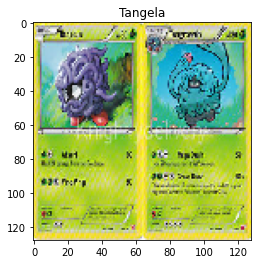

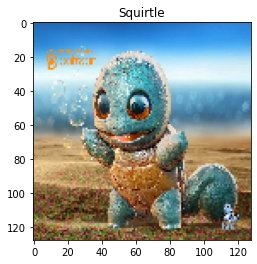

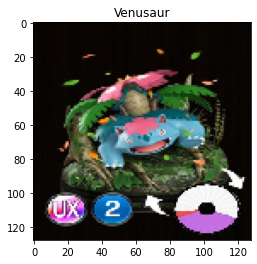

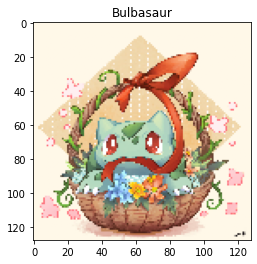

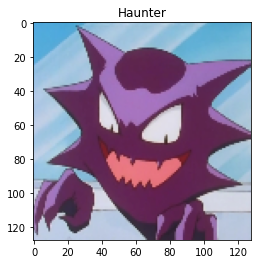

In [ ]:
# plot some of our training pokemon
def viewImg(img,label):
  plt.title(label2pokemon[label])
  plt.imshow(img)
  plt.show()
X = np.array(image_data)
Y = np.array(labels)
# plot 5 random pokemon
for i in range(5):
  r = np.random.randint(10179)
  viewImg(X[r]/255.,Y[r])

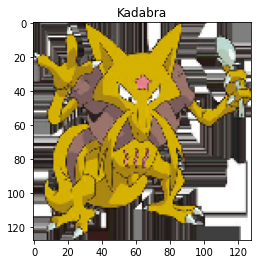

In [ ]:
#view the first pokemon in the array
viewImg(X[0]/255.,Y[0])

In [ ]:
#view the pokemon's NPN
labels[0]

64

In [ ]:
#verifying training label matches label
training_label[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
#returns indicies of non zeros in array
training_label[0].nonzero()

(array([64]),)

## CNN Model

In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(152, activation=tf.nn.softmax)
        
    ])
    
    return cnn_model
cnn_model = build_cnn_model()

cnn_model.predict(training_data[[0]])

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(training_data, training_label, test_size=0.20, shuffle= True)

In [ ]:
# cnn_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)
history = cnn_model.fit(x_train, y_train, validation_split=0.25, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/30
191/191 [==============================] - 4s 21ms/step - loss: 4.8519 - accuracy: 0.0364 - val_loss: 4.6634 - val_accuracy: 0.0486
Epoch 2/30
191/191 [==============================] - 3s 17ms/step - loss: 4.4123 - accuracy: 0.0763 - val_loss: 4.2124 - val_accuracy: 0.0958
Epoch 3/30
191/191 [==============================] - 3s 17ms/step - loss: 3.9194 - accuracy: 0.1413 - val_loss: 3.8105 - val_accuracy: 0.1586
Epoch 4/30
191/191 [==============================] - 3s 17ms/step - loss: 3.2853 - accuracy: 0.2489 - val_loss: 3.5832 - val_accuracy: 0.2019
Epoch 5/30
191/191 [==============================] - 3s 17ms/step - loss: 2.5306 - accuracy: 0.3940 - val_loss: 3.4664 - val_accuracy: 0.2485
Epoch 6/30
191/191 [==============================] - 3s 17ms/step - loss: 1.8706 - accuracy: 0.5386 - val_loss: 3.6971 - val_accuracy: 0.2534
Epoch 7/30
191/191 [==============================] - 3s 17ms/step - loss: 1.2794 - accuracy: 0.6759 - val_loss: 3.7854 - val_accuracy: 0.2844

## Viewing Predictions

In [ ]:
predictions = cnn_model.predict(x_test)


In [ ]:
predictions[0]

array([3.18602783e-13, 4.10300527e-06, 3.30177521e-08, 1.57882152e-08,
       1.00623856e-06, 1.14755011e-07, 7.95514488e-11, 3.75160416e-05,
       1.89252899e-06, 1.36461067e-05, 1.80436871e-07, 1.75847390e-07,
       1.34516904e-06, 3.48043545e-06, 4.85987869e-07, 3.80226979e-08,
       3.36435951e-05, 3.17453477e-08, 5.01464513e-07, 2.18979456e-03,
       1.55966477e-02, 4.35895287e-03, 1.35901631e-04, 9.19912964e-08,
       1.21665380e-08, 3.88023363e-06, 3.49382070e-08, 2.27393002e-06,
       1.38722482e-08, 3.88600142e-07, 3.51825906e-06, 3.35524455e-14,
       1.71260353e-06, 1.93739994e-04, 1.34989561e-04, 1.65569654e-05,
       1.40889920e-03, 3.38779537e-05, 1.67879989e-04, 1.18459808e-04,
       3.30653493e-05, 4.70232209e-07, 2.97398770e-07, 3.14629710e-06,
       4.14057382e-07, 1.65744143e-06, 3.67785378e-06, 4.36613334e-07,
       1.56186834e-05, 4.34076610e-05, 4.93140100e-03, 2.56530545e-03,
       1.67179026e-03, 5.21148881e-03, 2.39581482e-06, 5.09073971e-07,
      

In [ ]:
prediction = np.argmax(predictions[0])
print(prediction)
print(label2pokemon[prediction])

143
Snorlax


In [ ]:
y_test[0].nonzero()

(array([143]),)

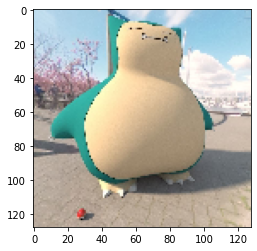

In [ ]:
def viewPred(img):
  plt.imshow(img)
  plt.show()
viewPred(x_test[0])

## Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


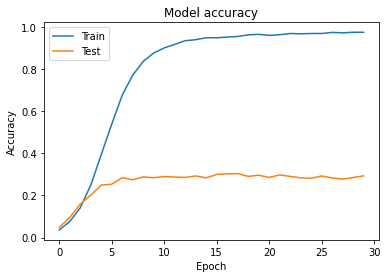

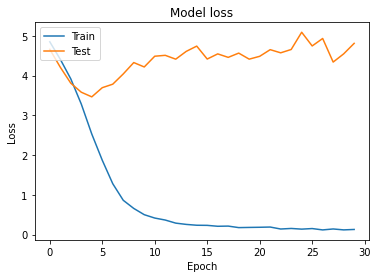

In [ ]:
print(history.history.keys())
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
# test_loss, test_acc = # TODO

print('Test accuracy:', test_acc)

64/64 [==============================] - 0s 7ms/step - loss: 5.0869 - accuracy: 0.2716
Test accuracy: 0.2716110050678253
